In [4]:
cd /home/jovyan/GA_DSI/Projects/capstone

/home/jovyan/GA_DSI/Projects/capstone


In [45]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lib.general_utilities as gu

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from collections import Counter
import itertools
from wordcloud import WordCloud
import seaborn as sns

from sklearn.metrics import classification_report,precision_recall_curve,confusion_matrix 
from sklearn.metrics import (precision_score,accuracy_score,roc_auc_score,roc_curve, 
                             precision_recall_curve,recall_score,make_scorer,auc)
from tqdm import tqdm

# storing data directories for this notebook.
img_out_dir = 'data/images/Modelling_NB3_70PercConf_noEmojiEncoding/CrossVal/'
data_out_dir = 'data/pickled/Modelling_NB3_70PercConf_noEmojiEncoding/CrossVal/'

%matplotlib inline

## Let's run our text data, through some models and see how they predict.

```At this point I have the following data that I want to compare results for:```
```
1. raw text
2. cleaned text
3. stopwords processed and cleaned text
4. stemmed, stopwords processed and cleaned text```

In [6]:
#***********************************************************************************

In [9]:
# Load pickled dataset.
filename = 'data/processed_dataset_df/airline_proc_dataset_70percCL_noEmEnc_addLemma_df'
air_full_df = gu.read_pickle_obj(filename)

In [10]:
air_full_df.head(11)

,airline,airline_sentiment,text,clean_text,stopw_clean_text,stem_stopw_clean_text,lemma_stopw_clean_text,negativereason,airline_sentiment_confidence
0,Virgin America,neutral,@VirginAmerica What @dhepburn said.,what said,said,said,said,NaN,1.0
1,Virgin America,negative,@VirginAmerica it's really aggressive to blast...,its really aggressive to blast obnoxious enter...,really aggressive blast obnoxious entertainmen...,realli aggress blast obnoxi entertain guest fa...,really aggressive blast obnoxious entertainmen...,Bad Flight,1.0
2,Virgin America,negative,@VirginAmerica and it's a really big bad thing...,and its a really big bad thing about it,really big bad thing,realli big bad thing,really big bad thing,Can't Tell,1.0
3,Virgin America,negative,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay 30 a flight for seats that...,seriously pay 30 seats didnt playing really ba...,serious pay 30 seat didnt play realli bad thin...,seriously would pay 30 flight seat didnt playi...,Can't Tell,1.0
4,Virgin America,positive,"@VirginAmerica it was amazing, and arrived an ...",it was amazing and arrived an hour early youre...,amazing arrived hour early youre good,amaz arriv hour earli your good,amazing arrived hour early youre good,NaN,1.0
5,Virgin America,positive,@VirginAmerica I &lt;3 pretty graphics. so muc...,i lt3 pretty graphics so much better than mini...,lt3 pretty graphics better minimal iconography d,lt3 pretti graphic better minim iconographi d,lt3 pretty graphic much better minimal iconogr...,NaN,1.0
6,Virgin America,positive,@VirginAmerica This is such a great deal! Alre...,this is such a great deal already thinking abo...,great deal thinking 2nd trip amp havent gone 1...,great deal think 2nd trip amp havent gone 1st ...,great deal already thinking 2nd trip amp haven...,NaN,1.0
7,Virgin America,positive,@VirginAmerica Thanks!,thanks,thanks,thank,thanks,NaN,1.0
8,Virgin America,positive,@VirginAmerica So excited for my first cross c...,so excited for my first cross country flight l...,excited cross country lax mco ive heard great ...,excit cross countri lax mco ive heard great th...,excited first cross country flight lax mco ive...,NaN,1.0
9,Virgin America,negative,@VirginAmerica I flew from NYC to SFO last we...,i flew from nyc to sfo last week and couldnt f...,flew nyc sfo week fully sit seat large gentlem...,flew nyc sfo week fulli sit seat larg gentlema...,flew nyc sfo last week couldnt fully sit seat ...,Bad Flight,1.0


In [11]:
# Data has not emoji encoding. They will be ingnored by data transformer.

In [12]:
# dataset size.
air_full_df.shape

(10768, 9)

In [13]:
# column names
air_full_df.columns

Index(['airline', 'airline_sentiment', 'text', 'clean_text',
       'stopw_clean_text', 'stem_stopw_clean_text', 'lemma_stopw_clean_text',
       'negativereason', 'airline_sentiment_confidence'],
      dtype='object')

In [14]:
# airlines.
air_full_df.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

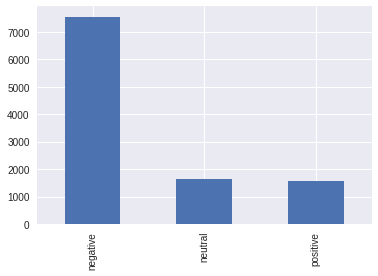

In [15]:
air_full_df.airline_sentiment.value_counts().plot(kind='bar')

In [16]:
#****** Highly imbalanced. 

In [17]:
def log_output(dataset_name, model_name, sc_output, pipe):
    '''
    This method logs the output of a model pipeline.
    '''
    
    entry = {                
                'dataset'        :  dataset_name,
                'model'          :  model_name,
                'tr_acc_score'   :  sc_output['train_score'],
                'tst_acc_score'  :  sc_output['test_score'],
                'pipe_object'    :  pipe,
                'y_pred'         :  sc_output['y_pred'],
                'ypred_proba'    :  sc_output['ypred_proba'],
                'ytest'          :  sc_output['ytest']
            }
    return(entry)

In [18]:
# Gridsearch to find best model.
def gs_fit_score_pipeline(pipe, Xtrain, Xtest, ytrain, ytest, param_grid, target_names):
    '''
    This method grid searches a pipeline, with parameters in the param_grid, 
    to find best model with tuned hyper paramters.
    '''
    
    gs = GridSearchCV(pipe, cv = 5, param_grid=param_grid)
  
    # Fit and score pipeline.
    gs.fit(Xtrain, ytrain) 
    
    # Mean accuracy score is returned.
    train_score = gs.score(Xtrain,ytrain)
    test_score = gs.score(Xtest,ytest)  
    y_pred = gs.predict(Xtest)
    
       
    output = {'train_score':train_score, 
              'test_score':test_score,
              }
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
    
    return(output, class_report_str, conf_matrix_raw)

In [19]:
# fit score pipeline of models. Good for benchmarking.
def fit_score_pipeline(pipe, X, y, target_names):
    '''
    This method fits and scores pipeline of models. Its good for benchmarking.
    '''    
  
    # train test split our X and y.
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=42)
    # Fit and score pipeline.
    pipe.fit(Xtrain, ytrain) 
    
    # Use cross validation to get a mean accuracy score of model.
    scores = []
    scores = cross_val_score(pipe, Xtrain, ytrain, cv=5, scoring='accuracy')
    train_score = scores.mean()
    
    scores = []
    scores = cross_val_score(pipe, Xtest, ytest, cv=5, scoring='accuracy')
    test_score = scores.mean()
    y_pred = pipe.predict(Xtest)
    ypred_proba = pipe.predict_proba(Xtest)
        
    output = {'train_score':train_score, 
              'test_score' :test_score,
              'y_pred'     :y_pred,
              'ytest'      :ytest,
              'ypred_proba':ypred_proba 
              }  
    
    #classification reports. 
    class_report_str = classification_report(ytest, y_pred, target_names=target_names)
    
    #confusion matrix.
    conf_matrix_raw = confusion_matrix(ytest, y_pred)
    
    return(output, class_report_str, conf_matrix_raw)

In [20]:
def execute_pipeline(pipe, param_grid, X, y, target_names, model_results, model_name,
                     classification_rep, confusion_mtx, data_desc):
    '''
    This method manages the pipeline fit and score execution, and keeps track of logging
    the results.  
    '''
                                    
    # Fit, score and get model stats.                                           
    sc_output, cl_report_str, conf_mtx = fit_score_pipeline(pipe, 
                                                            X,
                                                            y,
                                                            target_names=target_names)
       
    # Save classification report and confusion matrix, scaled data.
    key = model_name+" "+data_desc
    classification_rep[key] = cl_report_str
    key = model_name+" "+data_desc
    confusion_mtx[key] = conf_mtx
    
    # Log results.
    entry = log_output( dataset_name = data_desc, 
                        model_name   = model_name, 
                        sc_output    = sc_output,
                        pipe         = pipe)

    # Append the output for this model to a list.
    model_results.append(entry)

In [21]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          isNorm = False):
    '''
    This function plots and saves the confusion matrix.
    '''
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.grid('off')

    if (isNorm):
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
        print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="red")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    
    plt.savefig(img_out_dir+'BM_'+title+'.png')   
    plt.show()

In [22]:
def classifaction_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return(dataframe)

In [23]:
def plot_point(data, x, y, hue, title):    
    plt.figure(figsize=(8, 6))
    sns.pointplot(x=x, y=y, hue=hue, data=data)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.title(title)
    plt.tight_layout()

In [24]:
def plot_bar(data, x, y, hue, title):    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=x, y=y, hue=hue, data=data)
    plt.xticks(rotation=90, fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel(y, fontsize=12)
    plt.title(title)
    plt.tight_layout()

In [25]:
def plot_ROC(fpr,tpr,title, roc_auc):
    plt.title('Receiver Operating Characteristic '+title)
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(img_out_dir+'BM_ROC_'+title+'.png')
    plt.show()

### Let's see what is the accuracy that could be achieved by simply always predicting the most frequent class.
Target is ```airline sentiment```

In [26]:
y = air_full_df['airline_sentiment']

In [27]:
y.value_counts()

negative    7552
neutral     1634
positive    1582
Name: airline_sentiment, dtype: int64

In [28]:
yvalcnts = y.value_counts()
yvalcnts[0]/sum(yvalcnts)

0.70133729569093606

```Since this is a highly imbalanced dataset we see that:
A naive model that always predicts the'negative class' would be right 70% of the time.
This shows how classification accuracy may not be the best metric to score our model.
However it gives us a baseline of the least we should expect from our models.```

### Encode the target labels. 

In [29]:
# target.
y = air_full_df['airline_sentiment']

In [30]:
y.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [31]:
# Encode the target categories to a numeric number, using one hot encoding.
encoder = LabelEncoder()
y = encoder.fit_transform(air_full_df['airline_sentiment'])

In [32]:
encoder.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [33]:
# value counts of each class.
Counter(y)

Counter({0: 7552, 1: 1634, 2: 1582})

In [23]:
# 0:Negative, 1:neutral, 2:positive
# Classes of training data are imbalanced. 

In [24]:
# Create a document token matrix with CountVectorizer here. We are creating a numerical 
# representation of the words based on their count frequency in the 
# documents(in this case tweets)

In [25]:
# NOTE: RUN MODELS WITH CLEAN, STOPW_CLEAN and STEM_STOPW_CLEAN, text. Is there a difference
# in accuracy?

In [26]:
# NOTE: Analyze why I selected to run these.

## Create pipeline for benchmarking naive models.

In [35]:
# Make a dictionary of models to run.
# Using high C value for SVC and LR to provide minimal regularization.
modelsToexecute_dict = {'NaiveBayes': {'model':MultinomialNB(),
                                        'param_grid': ''},
                 'LogisticRegression': {'model':LogisticRegression(C=1000),
                                        'param_grid':''}                     
                       }

In [36]:
# Save mean accuracy scores, classification reports and confusion matrix.
model_results = []
confusion_mtx = {}
classification_rep = {}
cv_vectorizers = []
target_names=['negative', 'neutral', 'positive']

In [55]:
data_to_use = ['clean_text', 'stopw_clean_text', 'stem_stopw_clean_text', 'lemma_stopw_clean_text']
data_desc = ["clean text", "remove stopwords", "applied stemming", "lemmatized"]

In [38]:
for ind, text_set in tqdm(enumerate(data_to_use)):
    print("text data used for this iteration: "+ text_set)
    X = air_full_df[text_set] 
    
    for model_name, params in modelsToexecute_dict.items():  
        print("training model: "+ model_name)
        model = params['model']
        param_grid = params['param_grid']
        
        # Create a pipeline for the model.
        #pipe = make_pipeline(model)
        pipe = Pipeline([
                          ('vec', CountVectorizer()),
                          ('model', model)
                        ])

                
        execute_pipeline(pipe, param_grid, X, y, target_names, model_results, model_name,
                         classification_rep, confusion_mtx, data_desc[ind])
        

0it [00:00, ?it/s]

text data used for this iteration: clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


1it [00:05,  5.38s/it]

text data used for this iteration: stopw_clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


2it [00:08,  4.44s/it]

text data used for this iteration: stem_stopw_clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


3it [00:12,  4.09s/it]

text data used for this iteration: lemma_stopw_clean_text
trainiing model: NaiveBayes
trainiing model: LogisticRegression


4it [00:16,  4.01s/it]


In [39]:
# Put all modelling results in a dataframe.
model_results_df = pd.DataFrame(model_results)

# I am specifying the column arrangements.
model_results_df = model_results_df[['dataset', 'model', 'tr_acc_score', 'tst_acc_score',
                                     'pipe_object', 'y_pred', 'ytest', 'ypred_proba']]

In [40]:
# classification reports are returned by sklearn as a string.
# make it into a dataframe.
cl_report_df = pd.DataFrame()
dframes = []
for k,v in classification_rep.items():

    df = classifaction_report_df(v)    
    modname_desc = k.split()
    
    df['model'] = str(modname_desc[0])
    df['data_desc'] = str(' '.join(modname_desc[1:]))
    dframes.append(df)
    #print('*****  ' + k + '  Classification Report *****', '\n\n', v, '\n')
    
cl_report_df = pd.concat(dframes)
cl_report_df.reset_index(inplace=True)
cl_report_df.drop("index", axis=1, inplace=True)

In [46]:
# pickle benchmark results.

gu.pickle_obj(data_out_dir+'benchmark_model_results_ngrams1_1_df', model_results_df)
gu.pickle_obj(data_out_dir+'benchmark_count_vectorizers_ngrams1_1.obj', cv_vectorizers)
gu.pickle_obj(data_out_dir+'benchmark_class_report_ngrams1_1_df.obj', cl_report_df)
gu.pickle_obj(data_out_dir+'benchmark_class_report_sklearn_ngrams1_1.obj', classification_rep)

In [57]:
model_results_df

,dataset,model,tr_acc_score,tst_acc_score,pipe_object,y_pred,ytest,ypred_proba
0,clean text,NaiveBayes,0.818670,0.757203,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.276986055823, 0.70136884721, 0.02164509696..."
1,clean text,LogisticRegression,0.841074,0.814769,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.000141924008874, 0.999842745823, 1.5330167..."
2,remove stopwords,NaiveBayes,0.819714,0.779946,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.2546868438, 0.589602028781, 0.155711127419..."
3,remove stopwords,LogisticRegression,0.810656,0.784582,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 2, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.122244915004, 0.87010519278, 0.00764989221..."
4,applied stemming,NaiveBayes,0.813908,0.780409,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.204935495019, 0.634149659528, 0.1609148454..."
5,applied stemming,LogisticRegression,0.799511,0.760912,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.0574213565036, 0.930900800323, 0.011677843..."
6,lemmatized,NaiveBayes,0.821571,0.780880,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.222655890755, 0.616342498539, 0.1610016107..."
7,lemmatized,LogisticRegression,0.825163,0.787373,"Pipeline(steps=[('vec', CountVectorizer(analyz...","[1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.0212826215324, 0.960481542211, 0.018235836..."


In [60]:
cl_report_df.head(5)

,class,f1_score,precision,recall,support,model,data_desc
0,negative,0.89,0.80,0.99,1500.0,NaiveBayes,clean text
1,neutral,0.46,0.87,0.31,350.0,NaiveBayes,clean text
2,positive,0.68,0.90,0.55,304.0,NaiveBayes,clean text
3,negative,0.90,0.90,0.90,1500.0,LogisticRegression,clean text
4,neutral,0.65,0.65,0.65,350.0,LogisticRegression,clean text


## Visualize Classification Report Metrics.

### Accuracy of model for the different feature dimensions of the text data
```text data: cleaned only, stopwords added, stemming added.```

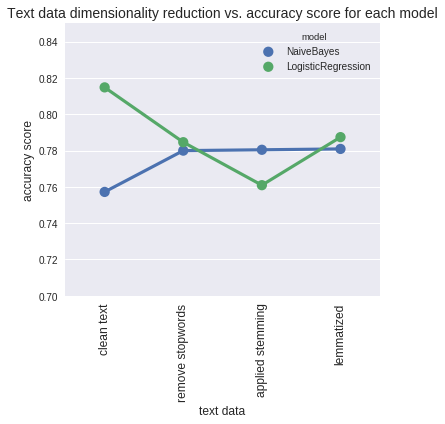

In [54]:
plt.figure(figsize=(6,6))
sns.pointplot(x="dataset", y= "tst_acc_score", hue="model", data=model_results_df)
plt.title('Text data dimensionality reduction vs. accuracy score for each model',
          fontsize=14)
plt.xlabel('text data', fontsize=12)
plt.xticks(fontsize=12, rotation =90)
plt.ylim(.7,.85)
plt.ylabel('accuracy score', fontsize=12)
plt.tight_layout()
plt.savefig(img_out_dir+'BM_model_accuracy_vs_feat_dim_reduction.png')

### Let's look at the classification report metrics: precision and recall, and confusion matrix

In [62]:
def plot_model_precision_recall(data, filename, data_type):
    plt.figure(figsize=(12,6))
    
    # plot precision.
    plt.subplot(1,2,1)
    sns.pointplot(x="model", y= "precision", hue="class", data=data)
    plt.title('Text data: ('+data_type+') vs. precision score for each model',
              fontsize=14)
    plt.xlabel('models', fontsize=12)
    plt.xticks(rotation=90,fontsize=12)
    plt.ylabel('precision score', fontsize=12)

    # plot recall.
    plt.subplot(1,2,2)
    sns.pointplot(x="model", y= "recall", hue="class", data=data)
    plt.title('Text data: ('+data_type+') vs. recall score for each model',
              fontsize=14)
    plt.xlabel('models', fontsize=12)
    plt.xticks(rotation=90,fontsize=12)
    plt.ylabel('recall score', fontsize=12)

    plt.tight_layout()
    plt.savefig(img_out_dir+filename)

In [63]:
data_desc = ["clean text", "remove stopwords", "applied stemming", "lemmatized"]

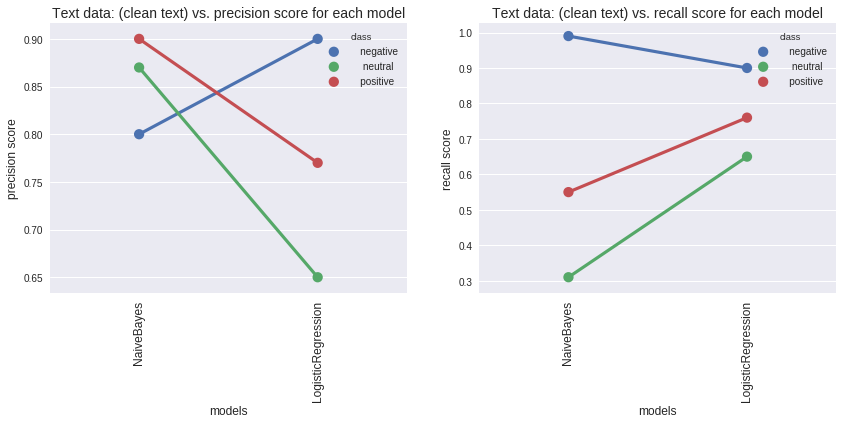

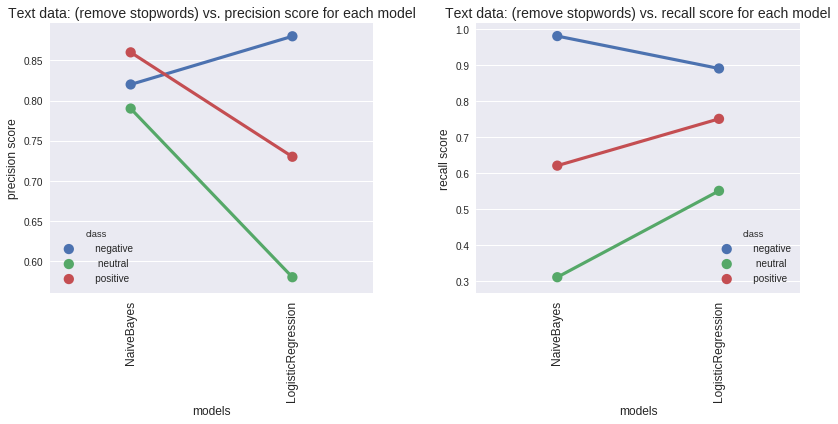

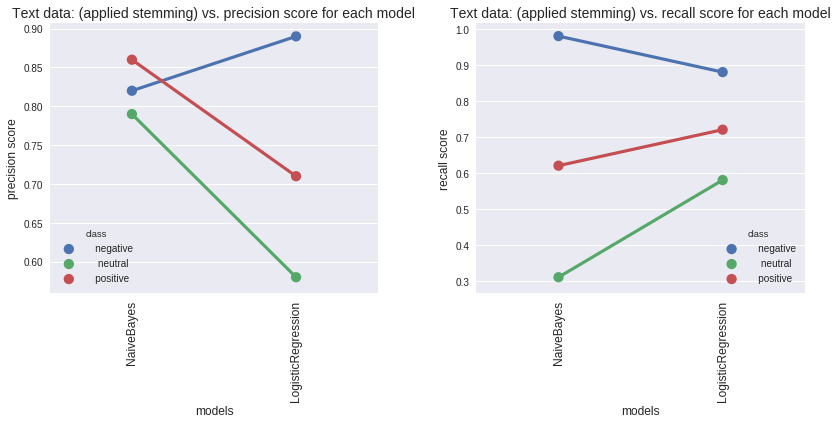

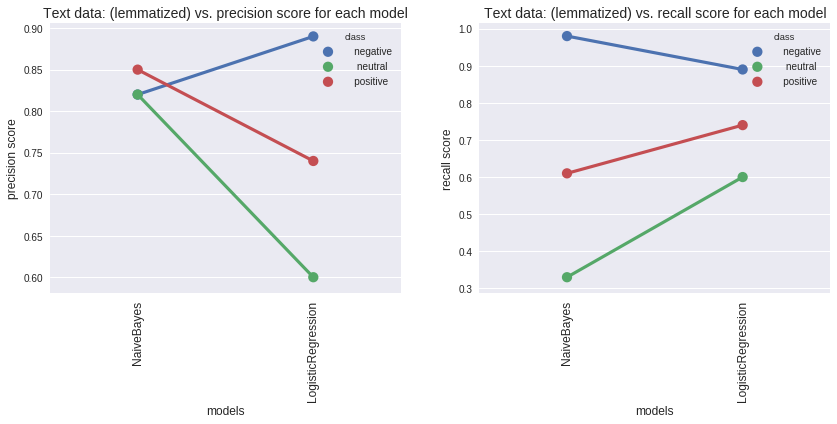

In [64]:
for data_type in data_desc:
    filename = 'BM_model_prec_recall_vs_models_'+data_type.replace(' ','')+'.png'
    data = cl_report_df[cl_report_df.data_desc==data_type]
    plot_model_precision_recall(data, filename, data_type)

In [65]:
# confusion matrix is used to evaluate the quality of the output of a classifier.
# The diagonal elements represent the number of points for which the predicted label 
# is equal to the true label, while off-diagonal elements are those that are mislabeled
# by the classifier.

In [66]:
# Metrics computed from a confusion matrix:

#    Classification Accuracy: Overall, how often is the classifier correct?
#    (TP + TN) / (TP + TN + FP + FN)

#    Classification Error: Overall, how often is the classifier incorrect?
#    (FP + FN) / (TP + TN + FP + FN)

#    Sensitivity: When the actual value is positive, how often is the prediction correct?
#    out of all positives, how many were true positives.
#    ***** This is Something we want to maximize. *****
#           How "sensitive" is the classifier to detecting positive instances?
#           Also known as "True Positive Rate" or "RECALL"
#                 TP / all positive
#                 all positive = TP + FN

#     Specificity: When the actual value is negative, how often is the prediction correct?
#     ***** This is Something we want to maximize. *****
#             How "specific" (or "selective") is the classifier in predicting positive instances?
#                 TN / all negative
#                 all negative = TN + FP

#     Precision: When a positive value is predicted, how often is the prediction correct?
#             How "precise" is the classifier when predicting positive instances?


Normalized confusion matrix
[[ 0.99  0.01  0.  ]
 [ 0.65  0.31  0.03]
 [ 0.44  0.02  0.55]]


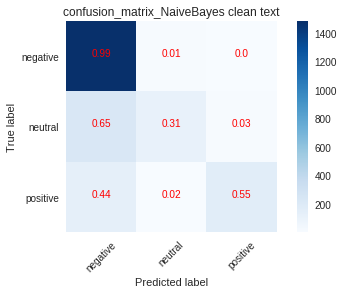

Normalized confusion matrix
[[ 0.9   0.07  0.03]
 [ 0.29  0.65  0.06]
 [ 0.17  0.07  0.76]]


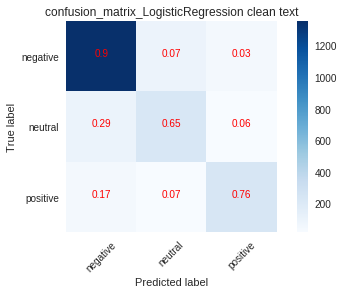

Normalized confusion matrix
[[ 0.98  0.01  0.01]
 [ 0.63  0.31  0.05]
 [ 0.36  0.03  0.62]]


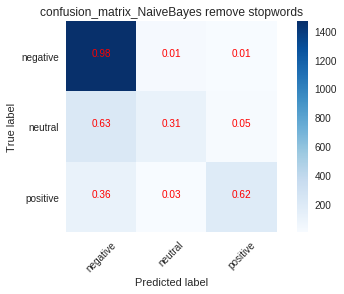

Normalized confusion matrix
[[ 0.89  0.08  0.03]
 [ 0.35  0.55  0.1 ]
 [ 0.18  0.07  0.75]]


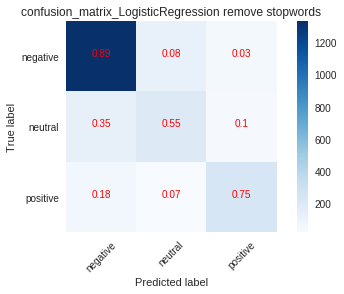

Normalized confusion matrix
[[ 0.98  0.01  0.01]
 [ 0.63  0.31  0.06]
 [ 0.35  0.03  0.62]]


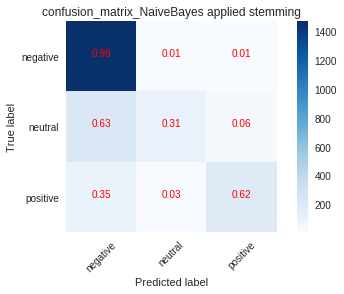

Normalized confusion matrix
[[ 0.88  0.08  0.04]
 [ 0.31  0.58  0.1 ]
 [ 0.19  0.09  0.72]]


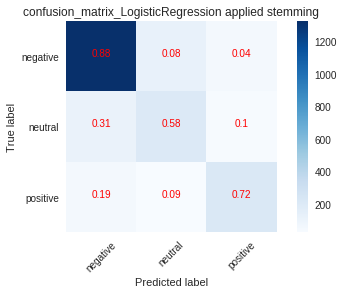

Normalized confusion matrix
[[ 0.98  0.01  0.01]
 [ 0.61  0.33  0.06]
 [ 0.36  0.03  0.61]]


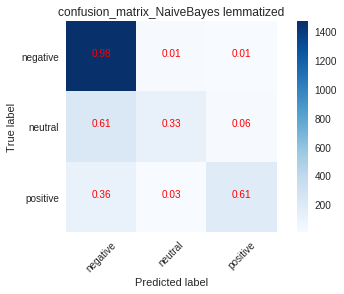

Normalized confusion matrix
[[ 0.89  0.08  0.03]
 [ 0.31  0.6   0.09]
 [ 0.18  0.08  0.74]]


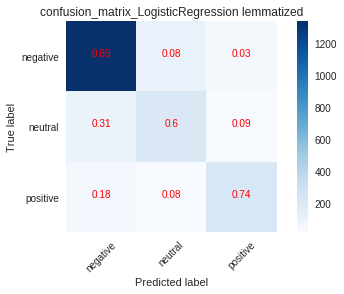

In [67]:
# Plot confusion matrices, for all models. Table that describes the performance of a classification model.
for k,conf_mtx in confusion_mtx.items():
    plot_confusion_matrix(conf_mtx, classes=target_names,
                          title= 'confusion_matrix_'+k,
                          isNorm='True')    

In [50]:
model_results_df.columns

Index(['dataset', 'model', 'tr_acc_score', 'tst_acc_score', 'pipe_object',
       'y_pred', 'ytest', 'ypred_proba'],
      dtype='object')

In [51]:
y_pred_prob = model_results_df.ypred_proba[0]

In [52]:
(model_results_df.y_pred[0]==0).sum(), (model_results_df.y_pred[0]==1).sum(), (model_results_df.y_pred[0]==2).sum()

(1765, 168, 221)

In [53]:
(model_results_df.ytest[0]==0).sum(), (model_results_df.ytest[0]==1).sum(), (model_results_df.ytest[0]==2).sum()

(1500, 350, 304)

In [54]:
y_test = model_results_df.ytest[0]

In [55]:
model_results_df.model[0]

'NaiveBayes'

In [56]:
# Predict sentiment of text.

In [57]:
nb_pipe = model_results_df.pipe_object[0]

In [58]:
nb_pipe.classes_

array([0, 1, 2])

In [59]:
X_in = cv.transform(["it was amazing"])

In [60]:
nb_pipe.predict(X_in)

array([2])

In [61]:
prob = nb_pipe.predict_proba(X_in)

In [62]:
prob[0]

array([ 0.30106953,  0.23759203,  0.46133844])

In [63]:
prob[0][0]

0.3010695347362618

In [64]:
text = air_full_df[air_full_df.airline_sentiment == 'positive']['clean_text'].values[5]
text

'i ❤️ flying ☺️👍'

In [65]:
X_in = cv.transform([text])
prob = nb_pipe.predict_proba(X_in)
prob, nb_pipe.predict(X_in)

(array([[ 0.7025772 ,  0.14905967,  0.14836313]]), array([0]))

In [66]:
# We see that text is clearly positive and the model mispredicts as negative.
# emojis are not being used as features yet. I will explore that next. It should help
# as a strong predictor, specially for positive tweets.

In [67]:
text = air_full_df[air_full_df.airline_sentiment == 'negative']['clean_text'].values[35]
text

'and now the flight flight booking problems site is totally down folks what is the problem'

In [68]:
X_in = cv.transform([text])
prob = nb_pipe.predict_proba(X_in)
prob, nb_pipe.predict(X_in)

(array([[  9.93448823e-01,   6.53235992e-03,   1.88168462e-05]]), array([0]))

In [69]:
# model predicts negative with strong class probability, as expected.

In [70]:
text = air_full_df[air_full_df.airline_sentiment == 'neutral']['clean_text'].values[35]
text

'to begin dallasaustin flights in april  889 ketr'

In [71]:
X_in = cv.transform([text])
prob = nb_pipe.predict_proba(X_in)
prob, nb_pipe.predict(X_in)

(array([[  2.98039655e-05,   9.96230106e-01,   3.74009013e-03]]), array([1]))